# Select White Dwarf-Main Sequence Wide Binaries
---

In this notebook, I use the [Gaia Data Release 3](https://arxiv.org/pdf/2206.05989.pdf) catalog as well as [Kareem El-Badry's catalog of one million wide binaries from Gaia DR2](https://arxiv.org/pdf/2101.05282.pdf) to obtain measurements of radial velocities from binary systems that consist of one white dwarf and one main sequence star. Radial velocities of main sequence stars in this notebook come from Gaia DR3 with some cuts made to ensure that we get good data, which will be described below. White dwarf radial velocities come from [this paper's first table](https://ui.adsabs.harvard.edu/abs/2017MNRAS.469.2102A/abstract) which gives the radial velocities of white dwarfs as well as an attempt at a gravitational redshift correction. The structure of this notebook is as follows:

1. Reading in data and building an initial catalog from El-Badry's catalog and Gaia DR3
2. Identifying which object in the El-Badry pairs is the white dwarf and which one is the main sequence star
3. Obtaining the radial velocity measurement of the white dwarfs from Anguiano, et al.
4. Obtaining the radial velocity measurement of the main sequence stars from Gaia DR3
5. Combining the data to get a gravitational redshift measurement

In [1]:
from sklearn.cluster import KMeans
import numpy as np
import scipy as sp
import sys
sys.path.append('../corv/src')

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from astropy.io import fits
from tqdm import tqdm
import pandas as pd
import corv

from astropy.table import Table, vstack, join
#from astropy.table import Table, join_skycoord
from astropy import units as u
from astropy.coordinates import SkyCoord

### Query
from astroquery.sdss import SDSS
from astroquery.gaia import Gaia
from astropy import constants as c
import data_selector as ds

using local paths
star and exposure catalogs not found! check paths and run make_catalogs() if you want to use sdss functionality. otherwise ignore.


In [2]:
#ds.select_sdss4()

In [3]:
catalog = ds.get_catalog('data/catalog_sdss4.csv', build_spectra = False)
catalog = Table.from_pandas(catalog)
print(len(catalog))

22563


Selecting all the stars in the color magnitude diagram that are below the line specified in El-Badry's wide binary catalog.

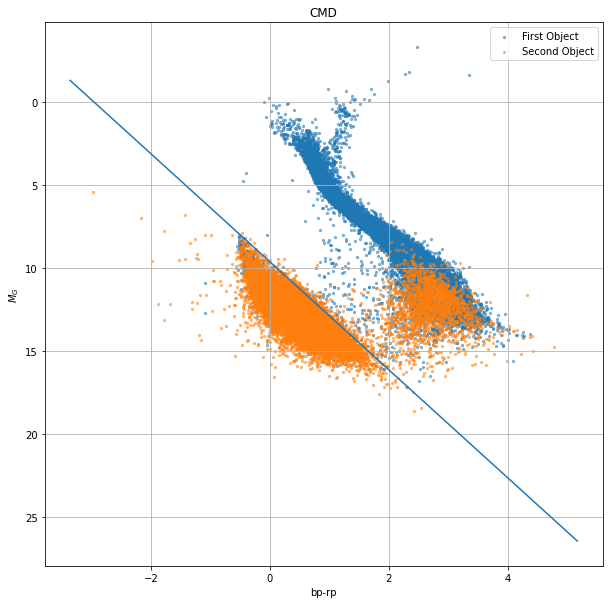

In [4]:
def wd_sep(bp_rp):
    return 3.25*bp_rp + 9.625

plt.figure(figsize=(10,10))

plt.scatter(catalog['bp_rp1'], catalog['phot_g_mean_mag1'] + 5 * (np.log10(catalog['parallax1'] / 100)), label='First Object', alpha = 0.5, s=5)
plt.scatter(catalog['bp_rp2'], catalog['phot_g_mean_mag2'] + 5 * (np.log10(catalog['parallax2'] / 100)), label='Second Object', alpha = 0.5, s=5)

plt.grid()
plt.ylabel(r'$M_G$')
plt.xlabel(r'bp-rp')
plt.title(r'CMD')
plt.gca().invert_yaxis()
xmin, xmax = plt.xlim()

plt.plot(np.linspace(xmin, xmax, num=100), wd_sep(np.linspace(xmin, xmax, num=100)))

plt.savefig('plots/selection/cmd.png')

plt.legend()
plt.show()

In [5]:
wd_obj = []
ms_obj = []
drop = []

for i in tqdm (range(len(catalog))):
    mg1 = wd_sep(catalog['bp_rp1'][i])
    mg2 = wd_sep(catalog['bp_rp2'][i])
    
    M1 = catalog['phot_g_mean_mag1'][i] + 5 * (np.log10(catalog['parallax1'][i] / 100))
    M2 = catalog['phot_g_mean_mag2'][i] + 5 * (np.log10(catalog['parallax2'][i] / 100))
    
    if M1 > mg1 and M2 < mg2:
        wd_obj.append(1)
        ms_obj.append(2)
    elif M2 > mg2 and M1 < mg1:
        wd_obj.append(2)
        ms_obj.append(1)
    else:
        drop.append(i)
               
catalog.remove_rows(drop)
catalog['wd_obj'] = wd_obj
catalog['ms_obj'] = ms_obj
#catalog.reset_index(inplace=True, drop=True)

100%|█████████████████████████████████████████████████████████████████| 22563/22563 [00:00<00:00, 106715.89it/s]


In [6]:
def separate(catalog, column, ms_obj, wd_obj, newname = ''):      
    mstemp_arr = [ catalog[str(column) + str(ms_obj[i])][i] for i in range(len(ms_obj)) ]
    wdtemp_arr = [ catalog[str(column) + str(wd_obj[i])][i] for i in range(len(wd_obj)) ]
    
    catalog['ms_' + str(column)] = mstemp_arr
    catalog['wd_' + str(column)] = wdtemp_arr
    return catalog

### ---

convert_cols = ['source_id', 'parallax', 'parallax_error', 'parallax_over_error', 'phot_g_mean_mag', 'phot_g_mean_flux',
                'phot_g_mean_flux_error', 'phot_bp_mean_mag', 'phot_bp_mean_flux', 'phot_bp_mean_flux_error',
                'phot_rp_mean_mag', 'phot_rp_mean_flux', 'phot_rp_mean_flux_error', 'bp_rp', 'pmra', 'ra', 'ra_error', 'pmdec', 'dec', 'dec_error', 'l', 'b']

for col in convert_cols:
    catalog = separate(catalog, col, ms_obj, wd_obj)
    
catalog['wd_m_g'] = catalog['wd_phot_g_mean_mag'] + 5 * np.log10(catalog['wd_parallax'] / 100)
catalog['ms_m_g'] = catalog['ms_phot_g_mean_mag'] + 5 * np.log10(catalog['ms_parallax'] / 100)

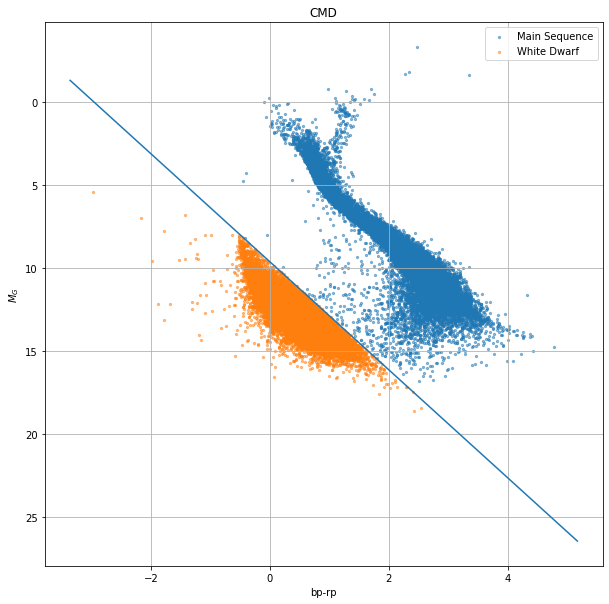

In [7]:
plt.figure(figsize=(10,10))

plt.scatter(catalog['ms_bp_rp'], catalog['ms_m_g'], label='Main Sequence', alpha = 0.5, s=5)
plt.scatter(catalog['wd_bp_rp'], catalog['wd_m_g'], label='White Dwarf', alpha = 0.5, s=5)

plt.grid()
plt.ylabel(r'$M_G$')
plt.xlabel(r'bp-rp')
plt.title(r'CMD')
plt.gca().invert_yaxis()
xmin, xmax = plt.xlim()

plt.plot(np.linspace(xmin, xmax, num=100), wd_sep(np.linspace(xmin, xmax, num=100)))

plt.savefig('plots/selection/wd_ms_cmd.png')

plt.legend()
plt.show()

## Select White Dwarf RV's
---

Load in the rv catalog Vedant sent by getting each RV's pmf.

In [8]:
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table, join_skycoord
from astropy import table

wd_rv = pd.read_table('data/wd_rvs/WD_table_public.dat', sep="\s+")
wd_rv = Table.from_pandas(wd_rv)

wd_rv = wd_rv[wd_rv['dec'] < 90]
wd_rv = wd_rv[wd_rv['dec'] > -90]

catalog['wd_pos'] = SkyCoord(catalog['wd_ra'], catalog['wd_dec'], unit='deg')
wd_rv['wd_pos'] = SkyCoord(wd_rv['ra'], wd_rv['dec'], unit='deg')

join_func = table.join_skycoord(5 * u.arcsecond)
catalog = table.join(catalog, wd_rv, join_funcs={'wd_pos': join_skycoord(5 * u.arcsec)})

Pull rv's from the catalog

In [9]:
#catalog.remove_rows(drops)
catalog['wd_rv'] = catalog['RVfit'] + catalog['vgr']
catalog['wd_erv'] = catalog['eRV']
#catalog.reset_index(inplace=True, drop=True)

print(len(catalog))

576


In [10]:
ADQL_CODE1 = "SELECT source_id, radial_velocity, radial_velocity_error \
    FROM gaiadr3.gaia_source \
    WHERE gaia_source.source_id IN {}\
    AND radial_velocity is not null\
    AND radial_velocity_error < 2\
".format(tuple(catalog['ms_source_id']))

job1 = Gaia.launch_job(ADQL_CODE1,dump_to_file=False)
d1 = job1.get_results()

In [11]:
print(d1)

     source_id      radial_velocity radial_velocity_error
                         km / s             km / s       
------------------- --------------- ---------------------
 587767172106520320       23.365816             1.3090714
 593915842991753088        1.311068            0.47882146
 611167253447201280       59.098064            0.48322064
 626494926574228352        8.362407             1.6132253
 635639049386379904       12.523048             1.0438299
 642837139695905024       24.224943             1.7233391
 647300091753069952       24.055807             0.5299358
 649472486214811776       33.172703             1.1175059
 667328520689073152      -36.405052             1.7640629
 679350202869273728        25.86198             0.5183527
                ...             ...                   ...
3843636017819394176         27.9711            0.58972716
3897577272299564928        5.138892             1.4232776
3921200760658023680       1.1367363             1.8322586
39309518138899

In [12]:
drops = []
rv = []
erv = []

for i in tqdm (range(len(catalog))):
    notfound = False
    a = np.where(catalog['ms_source_id'][i] == d1['source_id'])
    
    try:
        j = a[0][0]
    except:
        notfound = True
        
    if not notfound: 
        rv.append(d1['radial_velocity'][j])
        erv.append(d1['radial_velocity_error'][j])
    else:
        drops.append(i)   

catalog.remove_rows(drops)
catalog['ms_rv'] = rv
catalog['ms_erv'] = erv
#catalog.reset_index(inplace=True, drop=True)

100%|███████████████████████████████████████████████████████████████████████| 576/576 [00:00<00:00, 6372.05it/s]


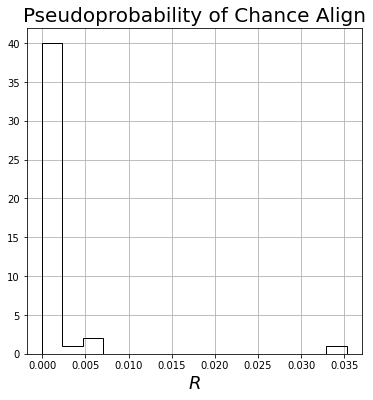

In [13]:
catalog = catalog[catalog['R_chance_align'] < 0.1]

catalog = catalog[catalog['wd_parallax'] > 0]
catalog = catalog[catalog['ms_parallax'] > 0]

catalog = catalog[catalog['wd_parallax_over_error'] > 5]
catalog = catalog[catalog['ms_parallax_over_error'] > 5]

catalog = catalog[catalog['wd_erv'] < 15]

#catalog['wd_rv_over_error'] = catalog['wd_rv'] / catalog['wd_erv']
#catalog['ms_rv_over_error'] = catalog['ms_rv'] / catalog['ms_erv']
#
#catalog = catalog[catalog['wd_rv_over_error'] > 1]
#catalog = catalog[catalog['ms_rv_over_error'] > 1]

plt.figure(figsize=(6,6))
plt.grid()
plt.hist(catalog['R_chance_align'], bins = 15, histtype='step', color='black')
ymin, ymax = plt.ylim()
#plt.vlines(np.mean(catalog['g_redshift']), ymin, ymax, linestyles='dashed')
plt.title('Pseudoprobability of Chance Align', fontsize=20)
plt.xlabel(r'$R$', fontsize=18)
plt.savefig('plots/selection/chancealign.png')

34.67592827179215
44


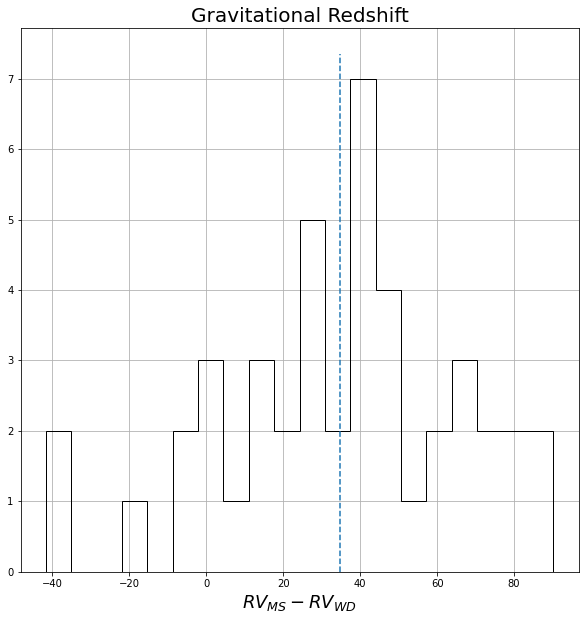

In [14]:
catalog['g_redshift'] = catalog['wd_rv'] - catalog['ms_rv']

#catalog = catalog[catalog['g_redshift'] > -100]
#catalog = catalog[catalog['g_redshift'] < 100]

print(np.mean(catalog['g_redshift']))
print(len(catalog))


plt.figure(figsize=(10,10))
plt.grid()
plt.hist(catalog['g_redshift'], bins = 20, histtype='step', color='black')
ymin, ymax = plt.ylim()
plt.vlines(np.mean(catalog['g_redshift']), ymin, ymax, linestyles='dashed')
plt.title('Gravitational Redshift', fontsize=20)
plt.xlabel(r'$RV_{MS} - RV_{WD}$', fontsize=18)
plt.savefig('plots/redshifts/gredshift.png')

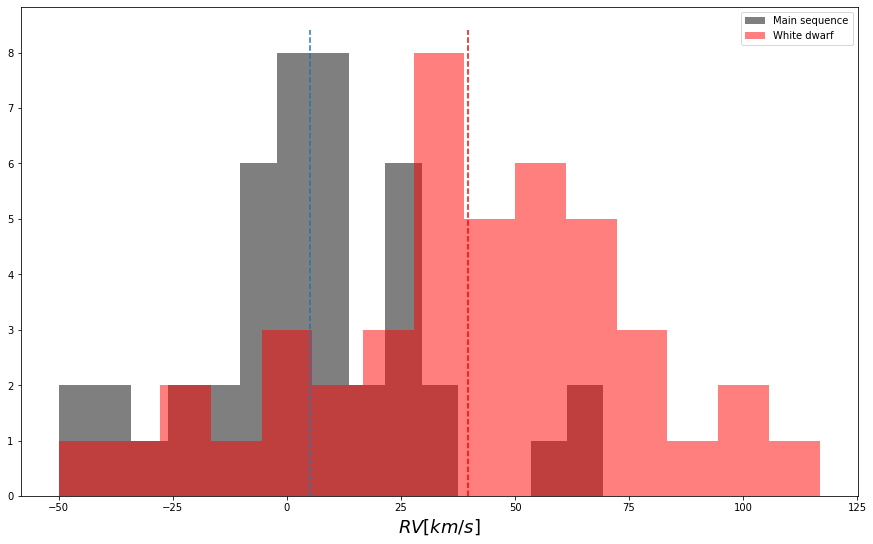

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 9))
#axes.grid()
axes.hist(catalog['ms_rv'], bins = 15, alpha=0.5, color='black', label='Main sequence')
axes.hist(catalog['wd_rv'], bins = 15, alpha=0.5, color='red', label='White dwarf')
ymin, ymax = axes.get_ylim()
axes.vlines(np.mean(catalog['ms_rv']), ymin, ymax, linestyles='dashed')
axes.vlines(np.mean(catalog['wd_rv']), ymin, ymax, linestyles='dashed', color='red')

#axes[0].set_title('Gravitational Redshift', fontsize=20)
axes.set_xlabel(r'$RV [km/s]$', fontsize=18)
axes.legend()
'''
axes[1].grid()
axes[1].hist(catalog['wd_rv'], bins = 15, histtype='step', color='black')
ymin, ymax = axes[1].get_ylim()
axes[1].vlines(np.mean(catalog['wd_rv']), ymin, ymax, linestyles='dashed')
#axes[1].title('Gravitational Redshift', fontsize=20)
axes[1].set_xlabel(r'$RV_{WD}$', fontsize=18)'''
plt.savefig('plots/redshifts/rvs_nostep.png')

4.979072
39.655


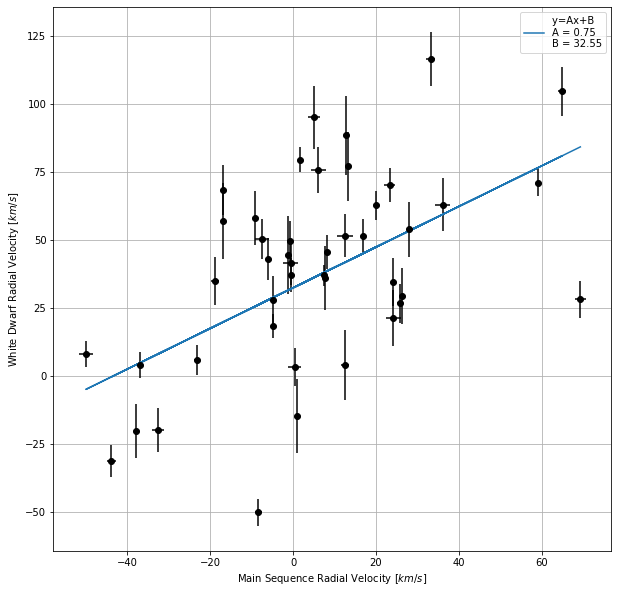

In [16]:
from scipy.optimize import curve_fit

def linear(x, A, B):
    return A*x+B

popt, pcov = curve_fit(linear, catalog['ms_rv'], catalog['wd_rv'], sigma = catalog['wd_erv'])

print(np.mean(catalog['ms_rv']))
print(np.mean(catalog['wd_rv']))

plt.figure(figsize=(10,10))
plt.errorbar(catalog['ms_rv'], catalog['wd_rv'], xerr=catalog['ms_erv'], yerr=catalog['wd_erv'], fmt = 'o', color='black')
plt.plot(catalog['ms_rv'], linear(catalog['ms_rv'], popt[0], popt[1]), label=("y=Ax+B \nA = {:2.2} \nB = {:2.2f}".format(popt[0], popt[1])))
plt.xlabel(r'Main Sequence Radial Velocity $[km/s]$')
plt.ylabel(r'White Dwarf Radial Velocity $[km/s]$')
plt.grid()
plt.legend()
plt.savefig('plots/redshifts/velocities.png')

In [17]:
catalog['eg_redshift'] = np.abs(catalog['ms_erv'] + catalog['wd_erv'])

In [18]:
print(r'Gravitational redshift: %2.2f +/- %2.2f km/s' % (np.mean(catalog['g_redshift']), np.mean(catalog['eg_redshift'])))

Gravitational redshift: 34.68 +/- 9.25 km/s


In [19]:
for key in catalog.keys():
    print(key)

wd_pos_id
Unnamed: 0
solution_id1
solution_id2
source_id1
source_id2
random_index1
random_index2
ref_epoch1
ref_epoch2
ra1
ra2
ra_error1
ra_error2
dec1
dec2
dec_error1
dec_error2
parallax1
parallax2
parallax_error1
parallax_error2
parallax_over_error1
parallax_over_error2
pm1
pm2
pmra1
pmra2
pmra_error1
pmra_error2
pmdec1
pmdec2
pmdec_error1
pmdec_error2
ra_dec_corr1
ra_dec_corr2
ra_parallax_corr1
ra_parallax_corr2
ra_pmra_corr1
ra_pmra_corr2
ra_pmdec_corr1
ra_pmdec_corr2
dec_parallax_corr1
dec_parallax_corr2
dec_pmra_corr1
dec_pmra_corr2
dec_pmdec_corr1
dec_pmdec_corr2
parallax_pmra_corr1
parallax_pmra_corr2
parallax_pmdec_corr1
parallax_pmdec_corr2
pmra_pmdec_corr1
pmra_pmdec_corr2
astrometric_n_obs_al1
astrometric_n_obs_al2
astrometric_n_obs_ac1
astrometric_n_obs_ac2
astrometric_n_good_obs_al1
astrometric_n_good_obs_al2
astrometric_n_bad_obs_al1
astrometric_n_bad_obs_al2
astrometric_gof_al1
astrometric_gof_al2
astrometric_chi2_al1
astrometric_chi2_al2
astrometric_excess_noise1
astro

In [20]:
catalog.remove_columns(['wd_pos_1', 'wd_pos_2'])

In [21]:
catalog.remove_column('Unnamed: 0')
catalog.write('data/01_catalog.fits', overwrite=True)

Comparison Code

In [22]:
ADQL_CODE1 = "SELECT \
        sdss.original_ext_source_id as bestobjid,\
        gaia_source.source_id\
        FROM gaiaedr3.gaia_source \
        JOIN gaiaedr3.sdssdr13_best_neighbour as sdss\
        ON gaia_source.source_id = sdss.source_id      \
        WHERE gaia_source.source_id IN {}\
    ".format(tuple(catalog['wd_source_id']))

job1 = Gaia.launch_job(ADQL_CODE1,dump_to_file=False)
d1 = job1.get_results()
print(len(d1))

43


In [23]:
drops = []
bestobjid1 = []

for i in tqdm (range(len(catalog))):
    notfound = False
    a = np.where(d1['source_id'] == catalog['wd_source_id'][i])
    
    try:
        j = a[0][0]
    except:
        notfound = True
        
    if not notfound: 
        try:
            bestobjid1.append(d1['bestobjid'][j])
        except:
            notfound = True
    if notfound:
        drops.append(i)    
        
catalog.remove_rows(drops)
catalog['wd_bestobjid'] = bestobjid1

100%|█████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 7077.37it/s]


In [24]:
print(catalog['wd_bestobjid'])

    wd_bestobjid   
-------------------
1237663305844981770
1237661136887349316
1237667538001068086
1237657190367035488
1237657190367035488
1237674461487431869
1237657070090321961
1237648721223745571
1237667429019418713
1237667113872982045
1237667254002122820
                ...
1237662224625238145
1237674649384189970
1237668297676685339
1237649962994565230
1237665530644398156
1237665430255042589
1237667550341496885
1237667551953420367
1237653617472176153
1237657595150729272
1237658204502818846
Length = 44 rows


In [25]:
from astropy.table import Table, vstack, hstack

stardats = []
iters = len(catalog)

SDSS_QUERY = """select bestObjID, plate, mjd, fiberID
    from dbo.SpecObjAll
    where bestObjID in {}""".format(tuple(catalog['wd_bestobjid']))

spec = SDSS.query_sql(SDSS_QUERY)


In [26]:
drops = []
plate = []
mjd = []
fiber = []

for i in tqdm (range(len(catalog))):
    notfound = False
    a = np.where(spec['bestObjID'] == catalog['wd_bestobjid'][i])
    
    try:
        j = a[0][0]
    except:
        notfound = True
        
    if not notfound: 
        try:
            
            plate.append(spec['plate'][j])
            mjd.append(spec['mjd'][j])
            fiber.append(spec['fiberID'][j])
            
            
        except:
            notfound = True
    if notfound:
        drops.append(i)    
        
catalog.remove_rows(drops)
catalog['plate'] = plate
catalog['mjd'] = mjd
catalog['fiber'] = fiber

100%|████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 25343.23it/s]


In [27]:
print(spec)


     bestObjID      plate  mjd  fiberID
------------------- ----- ----- -------
1237648721223745571   276 51909      73
1237649962994565230  2070 53405     508
1237649962994565230  2070 53729     518
1237652598500229164   723 52201     215
1237652629101412360   653 52145     141
1237653617472176153  7103 56661     692
1237655124478918660   851 52376     214
1237657070090321961  3650 55244     485
1237657070090321961  4239 55458     274
1237657190367035488   683 52524     119
1237657190367035488   386 51788     258
                ...   ...   ...     ...
1237667550341496885  2366 53741     496
1237667551953420367  2352 53770     127
1237667783346094312  4508 55600     503
1237668297676685339  2905 54580     114
1237668569321504963   344 51693     111
1237674461487431869  3819 55540     340
1237674649384189970  2569 54234      51
1237674649384189970  2409 54210      72
1237678660897013994  4310 55508     195
1237679434520789074  4367 55566     472
1237680500748976398  7142 56567     848


In [28]:
print(len(catalog))

44


In [29]:
spec = []
wl = []
fl = []
ivar = []
drops = []
worked = []

for i in tqdm(range(len(catalog))):
    try:
        spec = SDSS.get_spectra_async(plate=plate[i], fiberID=fiber[i], mjd=mjd[i])[0].get_fits()
        
        #print(spec[4].header)
        
        wl.append(10**spec[1].data['loglam'])
        fl.append(spec[1].data['flux'])
        ivar.append(spec[1].data['ivar'])
        worked.append(i)
    except:
        drops.append(i)
        
print(len(wl))
print(len(fl))
print(len(ivar))
        
catalog.remove_rows(drops)
catalog['wd_wl'] = wl
catalog['wd_fl'] = fl
catalog['wd_ivar'] = ivar

  0%|                                                                                    | 0/44 [00:00<?, ?it/s]/home/arseneausm/anaconda3/lib/python3.8/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
100%|██████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 152.71it/s]

44
44
44


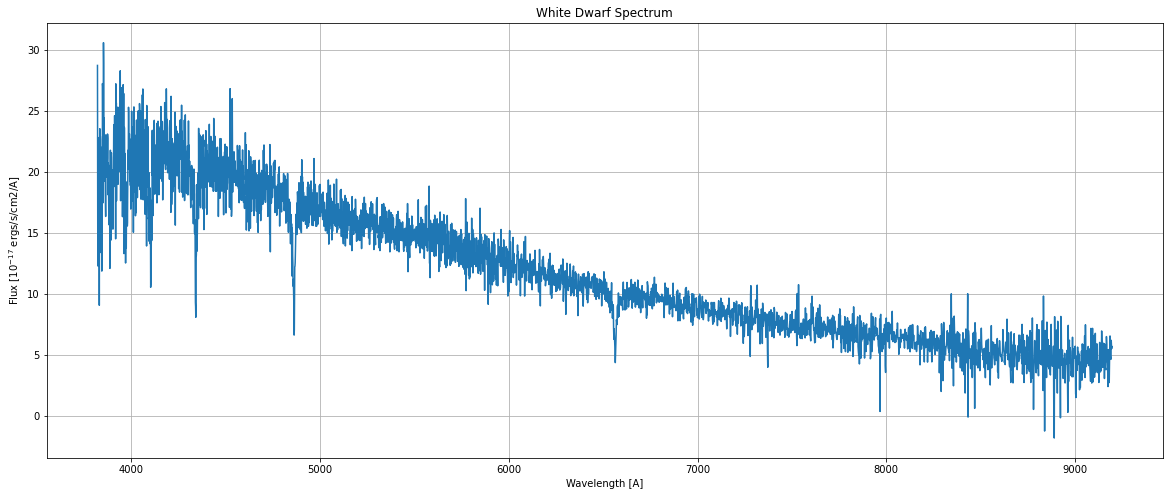

In [30]:
i = 1

plt.figure(figsize=(20,8))

plt.plot(catalog['wd_wl'][i], catalog['wd_fl'][i])
plt.grid()
plt.ylabel(r'Flux [$10^{-17}$ ergs/s/cm2/A]')
plt.xlabel(r'Wavelength [A]')
plt.title('White Dwarf Spectrum')
ax = plt.gca()

plt.show()

  2%|█▋                                                                          | 1/44 [00:00<00:16,  2.68it/s]

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
RV       115.5    -2500     2500     None     True     None     None
logg      8.42     4.51     9.49     None    False     None     None
res          1        0      inf     None    False     None     None
teff  1.239e+04     3001    4e+04     None    False     None     None


  5%|███▍                                                                        | 2/44 [00:00<00:19,  2.21it/s]

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
RV      -78.06    -2500     2500    6.124     True     None     None
logg     8.024     4.51     9.49        0    False     None     None
res          1        0      inf        0    False     None     None
teff      7893     3001    4e+04        0    False     None     None


  7%|█████▏                                                                      | 3/44 [00:01<00:23,  1.76it/s]

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
RV       73.67    -2500     2500    2.629     True     None     None
logg     8.981     4.51     9.49        0    False     None     None
res          1        0      inf        0    False     None     None
teff  1.359e+04     3001    4e+04        0    False     None     None


  9%|██████▉                                                                     | 4/44 [00:02<00:22,  1.80it/s]

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
RV       20.13    -2500     2500     None     True     None     None
logg     7.993     4.51     9.49     None    False     None     None
res          1        0      inf     None    False     None     None
teff      8188     3001    4e+04     None    False     None     None


 11%|████████▋                                                                   | 5/44 [00:02<00:21,  1.80it/s]

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
RV       20.13    -2500     2500     None     True     None     None
logg     7.993     4.51     9.49     None    False     None     None
res          1        0      inf     None    False     None     None
teff      8188     3001    4e+04     None    False     None     None


 14%|██████████▎                                                                 | 6/44 [00:03<00:18,  2.02it/s]

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
RV       48.22    -2500     2500     None     True     None     None
logg     8.358     4.51     9.49     None    False     None     None
res          1        0      inf     None    False     None     None
teff  1.345e+04     3001    4e+04     None    False     None     None


 16%|████████████                                                                | 7/44 [00:03<00:17,  2.07it/s]

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
RV       67.15    -2500     2500     None     True     None     None
logg     8.071     4.51     9.49     None    False     None     None
res          1        0      inf     None    False     None     None
teff  1.354e+04     3001    4e+04     None    False     None     None


 18%|█████████████▊                                                              | 8/44 [00:03<00:16,  2.21it/s]

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
RV       15.16    -2500     2500     None     True     None     None
logg     7.933     4.51     9.49     None    False     None     None
res          1        0      inf     None    False     None     None
teff  1.155e+04     3001    4e+04     None    False     None     None


 20%|███████████████▌                                                            | 9/44 [00:04<00:16,  2.10it/s]

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
RV       22.31    -2500     2500     None     True     None     None
logg     7.443     4.51     9.49     None    False     None     None
res          1        0      inf     None    False     None     None
teff      6607     3001    4e+04     None    False     None     None


 23%|█████████████████                                                          | 10/44 [00:04<00:16,  2.06it/s]

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
RV       46.22    -2500     2500     None     True     None     None
logg     8.106     4.51     9.49     None    False     None     None
res          1        0      inf     None    False     None     None
teff  1.354e+04     3001    4e+04     None    False     None     None


 25%|██████████████████▊                                                        | 11/44 [00:05<00:16,  2.03it/s]

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
RV       21.72    -2500     2500     None     True     None     None
logg     7.652     4.51     9.49     None    False     None     None
res          1        0      inf     None    False     None     None
teff      6642     3001    4e+04     None    False     None     None


 27%|████████████████████▍                                                      | 12/44 [00:05<00:15,  2.01it/s]

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
RV       111.6    -2500     2500     None     True     None     None
logg      9.49     4.51     9.49     None    False     None     None
res          1        0      inf     None    False     None     None
teff      8377     3001    4e+04     None    False     None     None


 30%|██████████████████████▏                                                    | 13/44 [00:06<00:14,  2.17it/s]

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
RV      -64.51    -2500     2500     None     True     None     None
logg     8.108     4.51     9.49     None    False     None     None
res          1        0      inf     None    False     None     None
teff  1.01e+04     3001    4e+04     None    False     None     None


 32%|███████████████████████▊                                                   | 14/44 [00:06<00:13,  2.29it/s]

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
RV       16.92    -2500     2500     None     True     None     None
logg     8.472     4.51     9.49     None    False     None     None
res          1        0      inf     None    False     None     None
teff  1.395e+04     3001    4e+04     None    False     None     None


 34%|█████████████████████████▌                                                 | 15/44 [00:07<00:12,  2.33it/s]

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
RV       53.64    -2500     2500     None     True     None     None
logg     8.447     4.51     9.49     None    False     None     None
res          1        0      inf     None    False     None     None
teff  1.312e+04     3001    4e+04     None    False     None     None


 36%|███████████████████████████▎                                               | 16/44 [00:07<00:11,  2.39it/s]

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
RV       34.09    -2500     2500     None     True     None     None
logg     8.654     4.51     9.49     None    False     None     None
res          1        0      inf     None    False     None     None
teff  1.072e+04     3001    4e+04     None    False     None     None


 39%|████████████████████████████▉                                              | 17/44 [00:07<00:10,  2.46it/s]

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
RV      -34.05    -2500     2500     None     True     None     None
logg     8.177     4.51     9.49     None    False     None     None
res          1        0      inf     None    False     None     None
teff      8418     3001    4e+04     None    False     None     None


 41%|██████████████████████████████▋                                            | 18/44 [00:08<00:10,  2.48it/s]

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
RV      -13.43    -2500     2500     None     True     None     None
logg     8.215     4.51     9.49     None    False     None     None
res          1        0      inf     None    False     None     None
teff      9363     3001    4e+04     None    False     None     None


 43%|████████████████████████████████▍                                          | 19/44 [00:08<00:10,  2.49it/s]

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
RV       48.06    -2500     2500     None     True     None     None
logg     8.454     4.51     9.49     None    False     None     None
res          1        0      inf     None    False     None     None
teff      8611     3001    4e+04     None    False     None     None


 45%|██████████████████████████████████                                         | 20/44 [00:09<00:10,  2.39it/s]

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
RV       43.61    -2500     2500     None     True     None     None
logg     8.314     4.51     9.49     None    False     None     None
res          1        0      inf     None    False     None     None
teff  1.348e+04     3001    4e+04     None    False     None     None


/home/arseneausm/anaconda3/lib/python3.8/site-packages/corv-0.1-py3.8.egg/corv/utils.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize = figsize)
 48%|███████████████████████████████████▊                                       | 21/44 [00:09<00:09,  2.30it/s]

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
RV       39.11    -2500     2500     None     True     None     None
logg     8.084     4.51     9.49     None    False     None     None
res          1        0      inf     None    False     None     None
teff      7323     3001    4e+04     None    False     None     None


 50%|█████████████████████████████████████▌                                     | 22/44 [00:10<00:09,  2.26it/s]

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
RV          16    -2500     2500     None     True     None     None
logg     7.837     4.51     9.49     None    False     None     None
res          1        0      inf     None    False     None     None
teff      7075     3001    4e+04     None    False     None     None


 52%|███████████████████████████████████████▏                                   | 23/44 [00:10<00:09,  2.32it/s]

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
RV       30.93    -2500     2500     None     True     None     None
logg     8.295     4.51     9.49     None    False     None     None
res          1        0      inf     None    False     None     None
teff      9170     3001    4e+04     None    False     None     None


 55%|████████████████████████████████████████▉                                  | 24/44 [00:10<00:08,  2.36it/s]

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
RV      -2.092    -2500     2500     None     True     None     None
logg     8.111     4.51     9.49     None    False     None     None
res          1        0      inf     None    False     None     None
teff      6526     3001    4e+04     None    False     None     None


 57%|██████████████████████████████████████████▌                                | 25/44 [00:11<00:07,  2.40it/s]

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
RV       5.562    -2500     2500     None     True     None     None
logg      8.33     4.51     9.49     None    False     None     None
res          1        0      inf     None    False     None     None
teff  1.008e+04     3001    4e+04     None    False     None     None


 59%|████████████████████████████████████████████▎                              | 26/44 [00:11<00:07,  2.31it/s]

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
RV       9.517    -2500     2500     None     True     None     None
logg     8.234     4.51     9.49     None    False     None     None
res          1        0      inf     None    False     None     None
teff  1.275e+04     3001    4e+04     None    False     None     None


 61%|██████████████████████████████████████████████                             | 27/44 [00:12<00:07,  2.18it/s]

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
RV      -43.79    -2500     2500     None     True     None     None
logg     9.416     4.51     9.49     None    False     None     None
res          1        0      inf     None    False     None     None
teff      8834     3001    4e+04     None    False     None     None


 64%|███████████████████████████████████████████████▋                           | 28/44 [00:12<00:07,  2.16it/s]

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
RV       33.54    -2500     2500     None     True     None     None
logg      7.89     4.51     9.49     None    False     None     None
res          1        0      inf     None    False     None     None
teff  1.425e+04     3001    4e+04     None    False     None     None


 66%|█████████████████████████████████████████████████▍                         | 29/44 [00:13<00:06,  2.28it/s]

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
RV       40.84    -2500     2500     None     True     None     None
logg      8.21     4.51     9.49     None    False     None     None
res          1        0      inf     None    False     None     None
teff      9407     3001    4e+04     None    False     None     None


 68%|███████████████████████████████████████████████████▏                       | 30/44 [00:13<00:06,  2.10it/s]

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
RV      -65.79    -2500     2500    1.075     True     None     None
logg     8.254     4.51     9.49        0    False     None     None
res          1        0      inf        0    False     None     None
teff  1.327e+04     3001    4e+04        0    False     None     None


 70%|████████████████████████████████████████████████████▊                      | 31/44 [00:14<00:06,  2.11it/s]

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
RV       27.66    -2500     2500     None     True     None     None
logg     7.763     4.51     9.49     None    False     None     None
res          1        0      inf     None    False     None     None
teff      7468     3001    4e+04     None    False     None     None


 73%|██████████████████████████████████████████████████████▌                    | 32/44 [00:14<00:05,  2.04it/s]

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
RV       20.91    -2500     2500     None     True     None     None
logg     9.286     4.51     9.49     None    False     None     None
res          1        0      inf     None    False     None     None
teff  1.012e+04     3001    4e+04     None    False     None     None


 75%|████████████████████████████████████████████████████████▎                  | 33/44 [00:15<00:05,  1.94it/s]

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
RV       55.76    -2500     2500     None     True     None     None
logg      8.25     4.51     9.49     None    False     None     None
res          1        0      inf     None    False     None     None
teff      8424     3001    4e+04     None    False     None     None


 77%|█████████████████████████████████████████████████████████▉                 | 34/44 [00:15<00:04,  2.03it/s]

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
RV       9.054    -2500     2500     None     True     None     None
logg     8.084     4.51     9.49     None    False     None     None
res          1        0      inf     None    False     None     None
teff      8131     3001    4e+04     None    False     None     None


 80%|███████████████████████████████████████████████████████████▋               | 35/44 [00:16<00:04,  1.84it/s]

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
RV       35.06    -2500     2500     None     True     None     None
logg     8.116     4.51     9.49     None    False     None     None
res          1        0      inf     None    False     None     None
teff  1.357e+04     3001    4e+04     None    False     None     None


 82%|█████████████████████████████████████████████████████████████▎             | 36/44 [00:16<00:04,  1.85it/s]

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
RV       15.21    -2500     2500   0.1133     True     None     None
logg     8.254     4.51     9.49        0    False     None     None
res          1        0      inf        0    False     None     None
teff  1.349e+04     3001    4e+04        0    False     None     None


 84%|███████████████████████████████████████████████████████████████            | 37/44 [00:17<00:03,  1.96it/s]

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
RV       49.97    -2500     2500    4.702     True     None     None
logg     8.029     4.51     9.49        0    False     None     None
res          1        0      inf        0    False     None     None
teff  1.39e+04     3001    4e+04        0    False     None     None


 86%|████████████████████████████████████████████████████████████████▊          | 38/44 [00:17<00:02,  2.04it/s]

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
RV      -17.01    -2500     2500     None     True     None     None
logg      8.39     4.51     9.49     None    False     None     None
res          1        0      inf     None    False     None     None
teff      9373     3001    4e+04     None    False     None     None


 89%|██████████████████████████████████████████████████████████████████▍        | 39/44 [00:18<00:02,  2.11it/s]

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
RV       31.95    -2500     2500     None     True     None     None
logg     8.365     4.51     9.49     None    False     None     None
res          1        0      inf     None    False     None     None
teff  1.265e+04     3001    4e+04     None    False     None     None


 91%|████████████████████████████████████████████████████████████████████▏      | 40/44 [00:18<00:01,  2.24it/s]

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
RV       36.69    -2500     2500     None     True     None     None
logg     9.186     4.51     9.49     None    False     None     None
res          1        0      inf     None    False     None     None
teff      9889     3001    4e+04     None    False     None     None


 93%|█████████████████████████████████████████████████████████████████████▉     | 41/44 [00:19<00:01,  2.24it/s]

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
RV       61.51    -2500     2500     None     True     None     None
logg     8.612     4.51     9.49     None    False     None     None
res          1        0      inf     None    False     None     None
teff  1.051e+04     3001    4e+04     None    False     None     None


 95%|███████████████████████████████████████████████████████████████████████▌   | 42/44 [00:19<00:00,  2.27it/s]

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
RV       42.35    -2500     2500     None     True     None     None
logg     8.525     4.51     9.49     None    False     None     None
res          1        0      inf     None    False     None     None
teff  1.333e+04     3001    4e+04     None    False     None     None


 98%|█████████████████████████████████████████████████████████████████████████▎ | 43/44 [00:19<00:00,  2.21it/s]

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
RV        34.5    -2500     2500   0.3668     True     None     None
logg     7.968     4.51     9.49        0    False     None     None
res          1        0      inf        0    False     None     None
teff      7359     3001    4e+04        0    False     None     None


100%|███████████████████████████████████████████████████████████████████████████| 44/44 [00:20<00:00,  2.17it/s]

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
RV      -17.27    -2500     2500     None     True     None     None
logg     7.885     4.51     9.49     None    False     None     None
res          1        0      inf     None    False     None     None
teff      5797     3001    4e+04     None    False     None     None


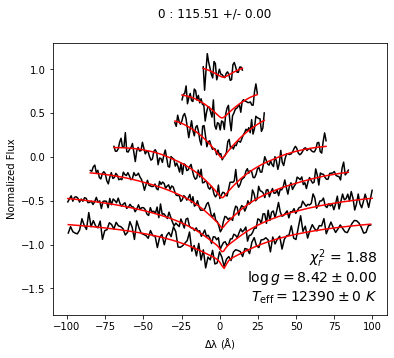

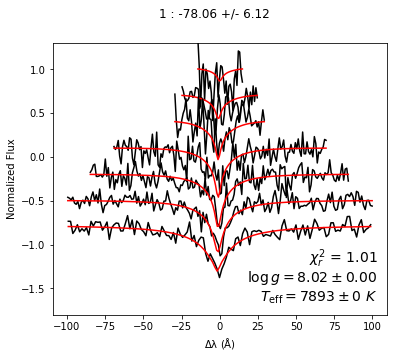

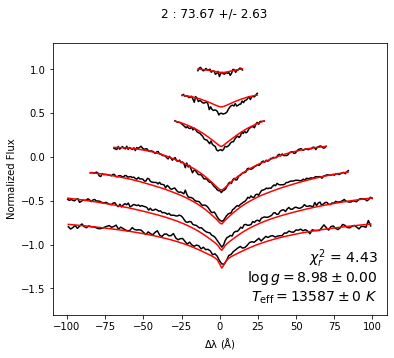

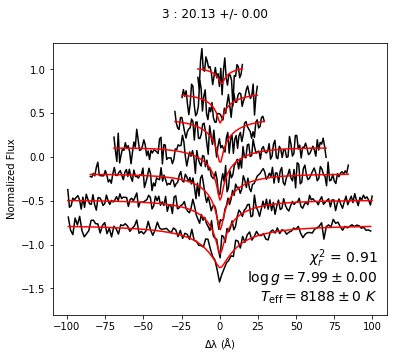

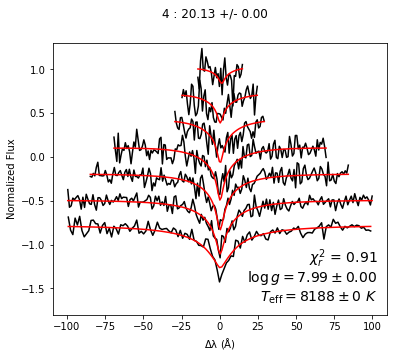

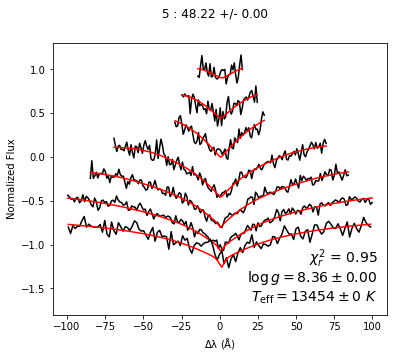

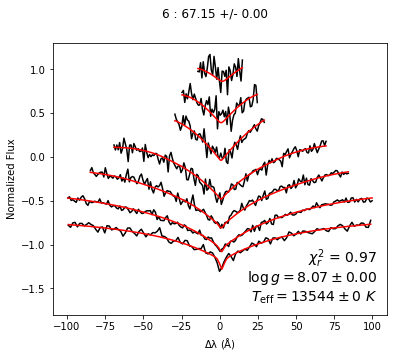

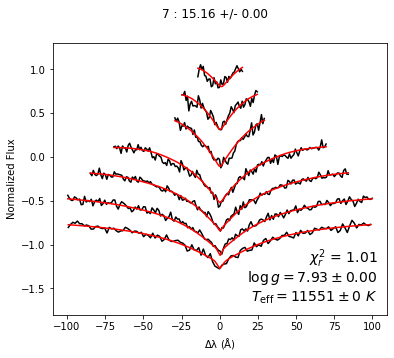

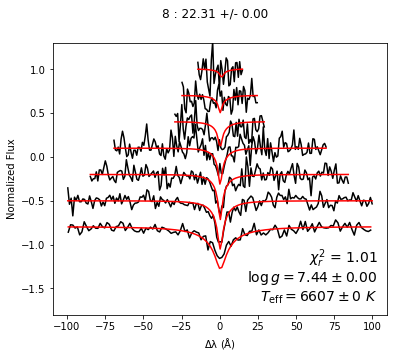

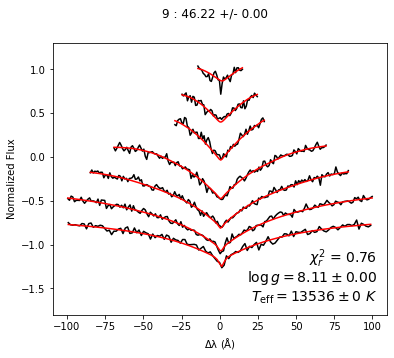

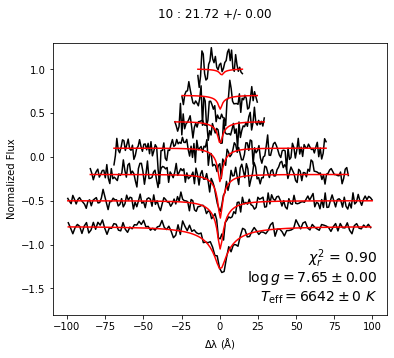

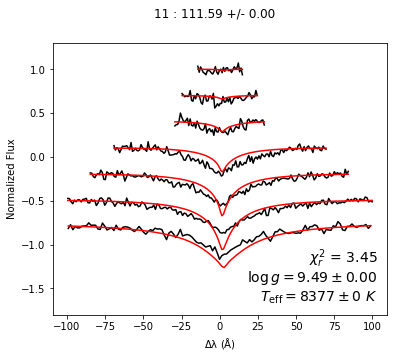

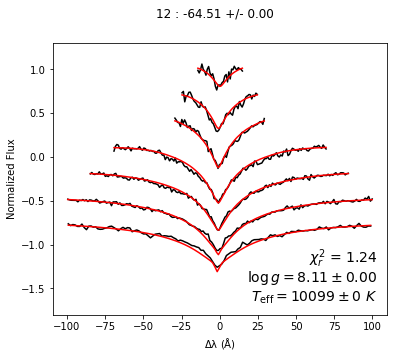

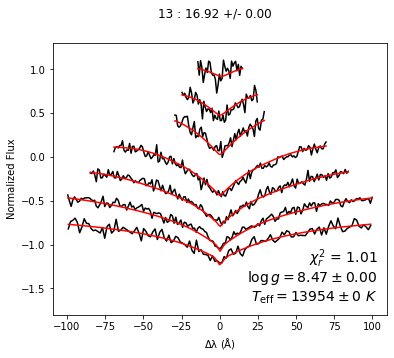

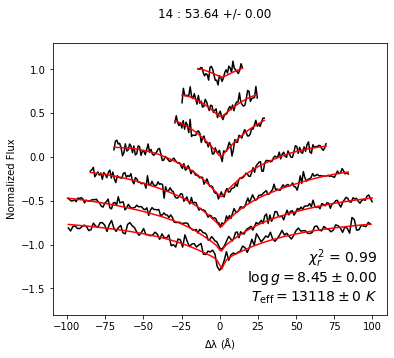

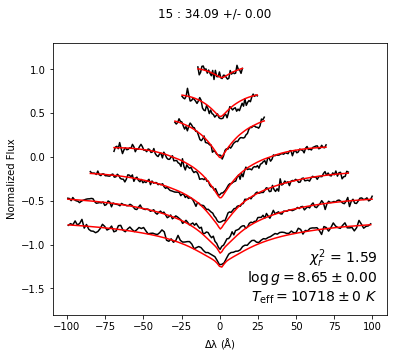

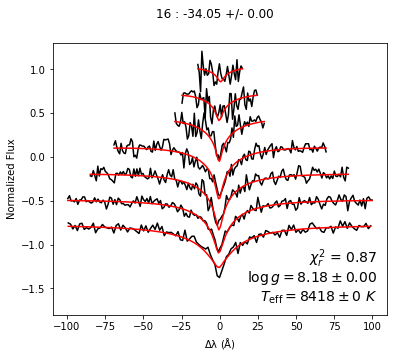

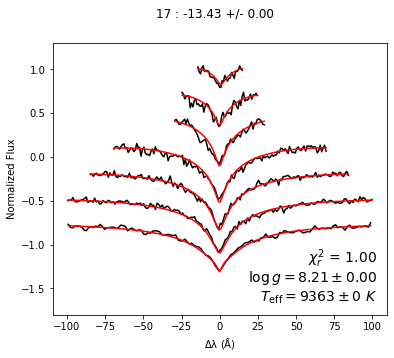

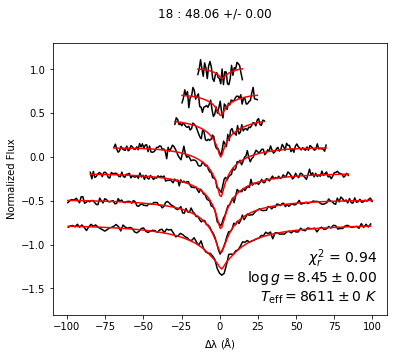

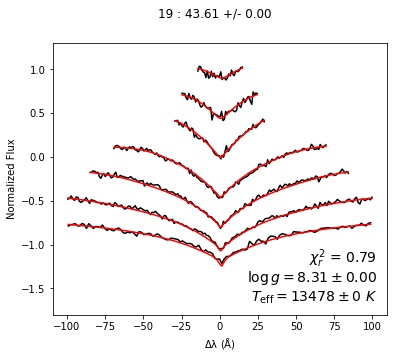

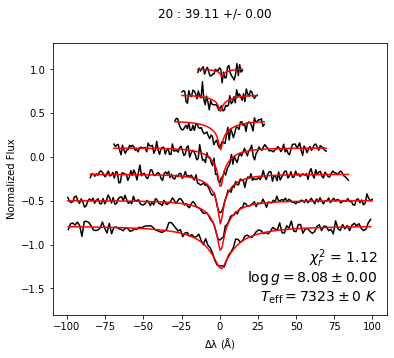

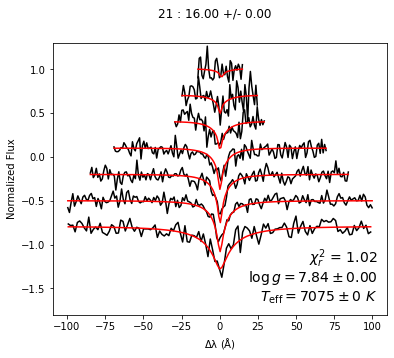

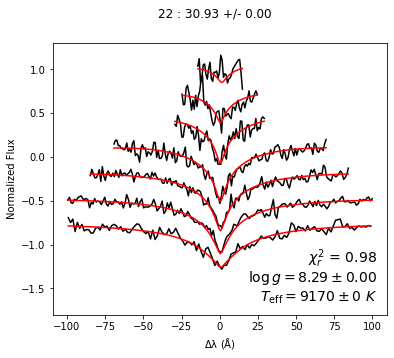

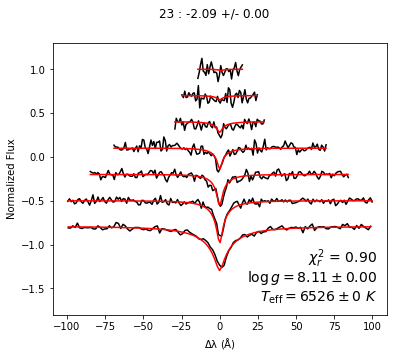

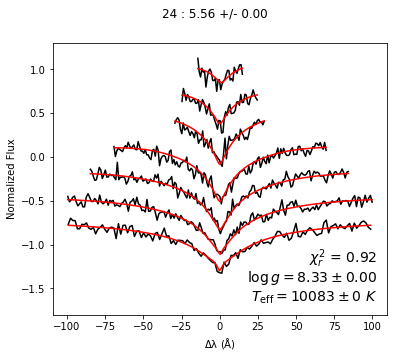

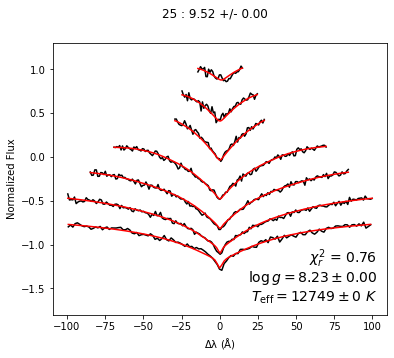

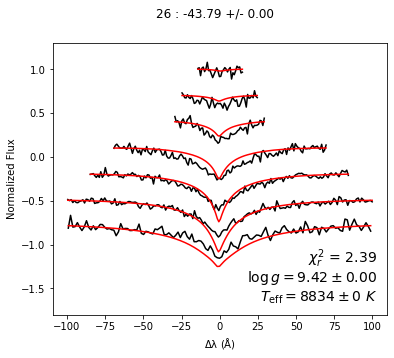

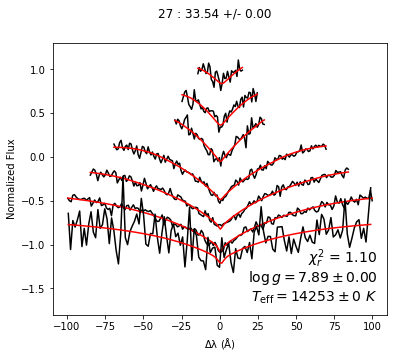

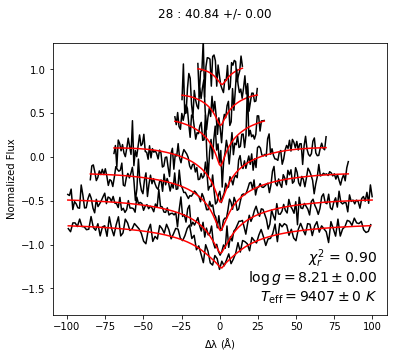

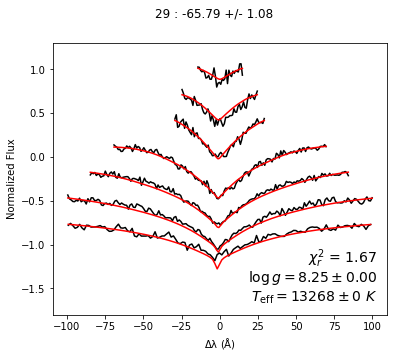

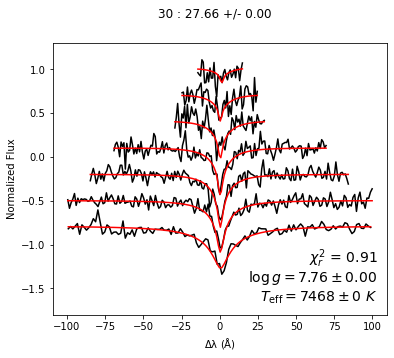

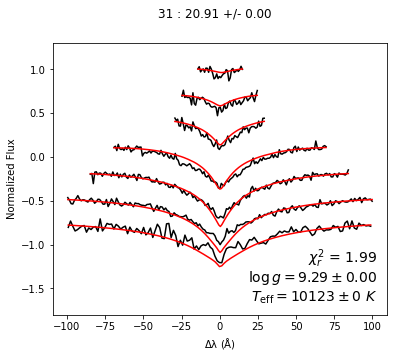

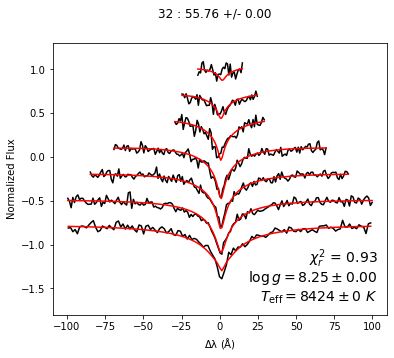

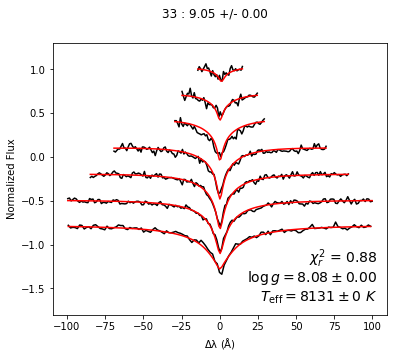

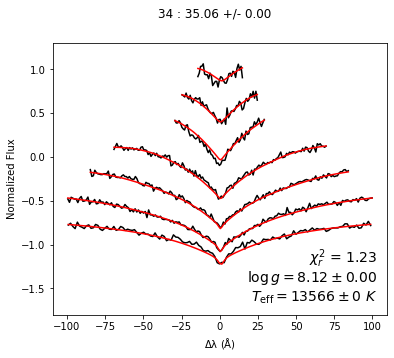

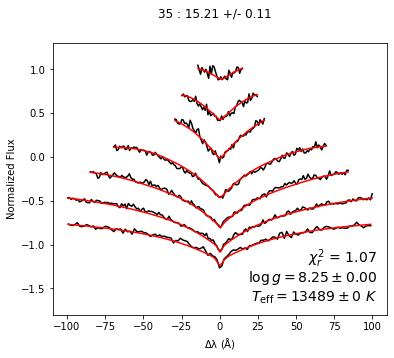

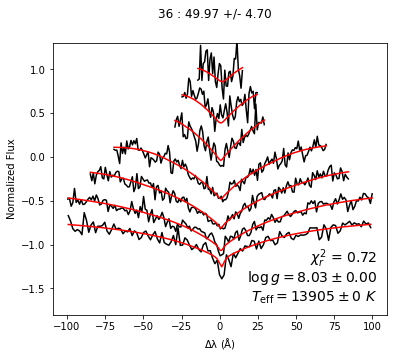

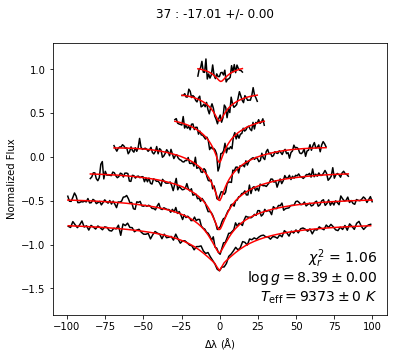

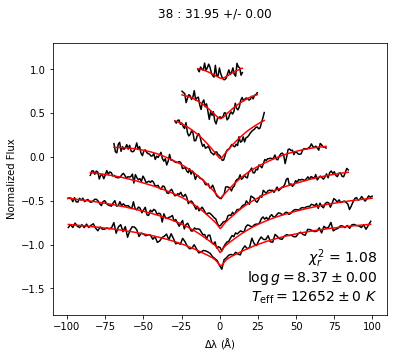

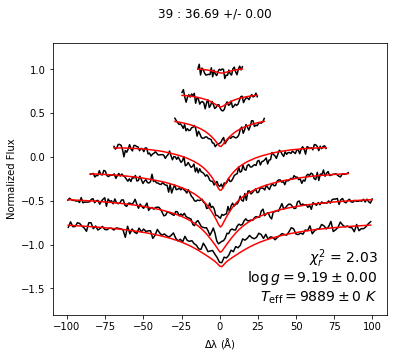

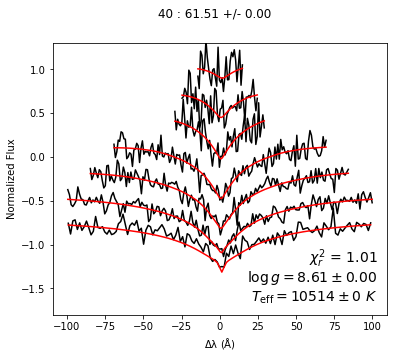

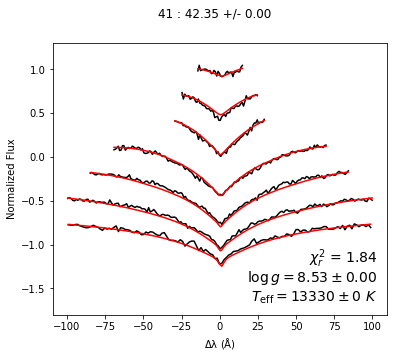

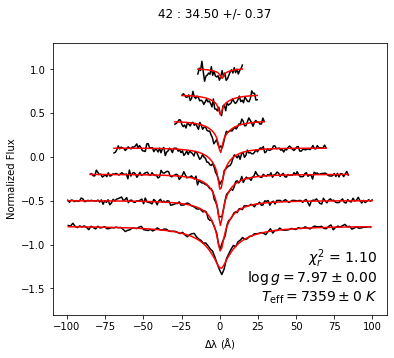

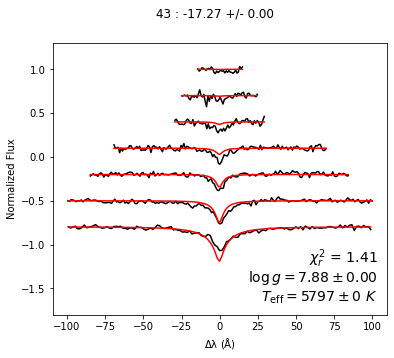

In [31]:
from lmfit import Parameters, fit_report, minimize

rvs = []
e_rvs = []

e_teff = []
e_logg = []

redchi = []
drops = []
figs = []

#catalog['wd_ivar'] = [catalog['wd_ivar'][i]  for i in range(len(catalog))]

for i in tqdm(range(len(catalog))):
    corvmodel = corv.models.make_koester_model()
    
    fl = np.array(catalog['wd_fl'][i])
    
    #for j in range(len(fl)):
    #    if fl[j] < 0:
    #        fl[j] = 0
    
    param_res, rv_res, rv_init = corv.fit.fit_corv(np.array(catalog['wd_wl'][i]), fl, np.array(catalog['wd_ivar'][i]), corvmodel)
    
    if rv_res.params['teff'].stderr == None:
        rv_res.params['teff'].stderr = 1e-6
    if rv_res.params['logg'].stderr == None:
        rv_res.params['logg'].stderr = 1e-6
    if rv_res.params['RV'].stderr == None:
        rv_res.params['RV'].stderr = 1e-6
    
    f = corv.utils.lineplot(np.array(catalog['wd_wl'][i]), np.array(catalog['wd_fl'][i]), np.array(catalog['wd_ivar'][i]), corvmodel, rv_res.params, gap = 0.3, printparams = True,
             figsize = (6, 5))
    
    f.suptitle('%d : %2.2f +/- %2.2f' % (i, rv_res.params['RV'].value, rv_res.params['RV'].stderr))
    figs.append(f)
    
    #f.savefig('spectra/corvfits/corvfit{}.jpg'.format(i))

    e_teff.append(rv_res.params['teff'].stderr)
    e_logg.append(rv_res.params['logg'].stderr)

    rvs.append(rv_res.params['RV'].value)
    e_rvs.append(rv_res.params['RV'].stderr)
    redchi.append(rv_res.redchi)


        
#catalog.remove_rows(drops)
catalog['rv'] = rvs
catalog['e_rv'] = e_rvs

catalog['e_teff'] = e_teff
catalog['e_logg'] = e_logg

catalog['e_rv'][catalog['e_rv'] == None] = 1e-6
catalog['rechi'] = redchi
catalog['figs'] = figs

23.142335487338674
39.655


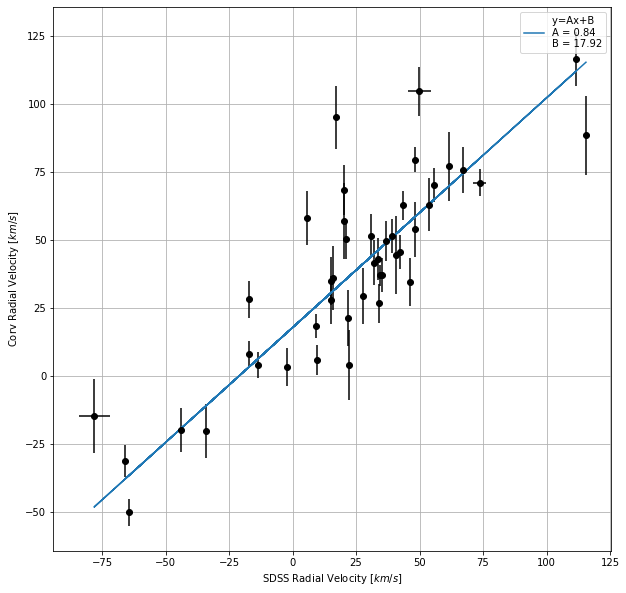

In [32]:
popt, pcov = curve_fit(linear, catalog['rv'], catalog['wd_rv'], sigma = catalog['wd_erv'])

print(np.mean(catalog['rv']))
print(np.mean(catalog['wd_rv']))

plt.figure(figsize=(10,10))
plt.errorbar(catalog['rv'], catalog['wd_rv'], xerr=catalog['e_rv'], yerr=catalog['wd_erv'], fmt = 'o', color='black')
plt.plot(catalog['rv'], linear(catalog['rv'], popt[0], popt[1]), label=("y=Ax+B \nA = {:2.2} \nB = {:2.2f}".format(popt[0], popt[1])))
plt.xlabel(r'SDSS Radial Velocity $[km/s]$')
plt.ylabel(r'Corv Radial Velocity $[km/s]$')
plt.grid()
plt.legend()
#plt.savefig('plots/redshifts/velocities.png')

In [33]:
import photoradius as pr

Loading pixel_info ...
Loading samples ...
Loading best_fit ...
Replacing NaNs in reliable distance estimates ...
Sorting pixel_info ...
Extracting hp_idx_sorted and data_idx at each nside ...
  nside = 64
  nside = 128
  nside = 256
  nside = 512
  nside = 1024
t = 73.396 s
  pix_info:   1.260 s
   samples:  21.664 s
      best:  39.860 s
       nan:   4.479 s
      sort:   5.916 s
       idx:   0.216 s
